In [466]:
import pandas as pd
import numpy as np

# **Overview of the data**:

In [506]:
df_1 = pd.read_csv('dataset.csv', sep="\t", quotechar="'")
df_2 = pd.read_csv('dataset_1.csv', sep="\t", quotechar="'")

df_1.drop('frame_number', inplace=True, axis=1)
df_2.drop('frame_number', inplace=True, axis=1)

df = df_1.append(df_2, ignore_index=True)

In [507]:
print("dataset has the shape : {} ".format(df.shape) )
print("{} rows and {} columns  \n\n".format(df.shape[0],df.shape[1] ) )

dataset has the shape : (4968, 15) 
4968 rows and 15 columns  




In [508]:
df.head()

,frame_time_epoch,frame_len,eth_src,device_name_src,eth_dst,device_name_dst,eth_type,ip_src,srcport,ip_dst,dstport,ip_proto,payload_utf8,action,attack
0,1.674747e+09,66,04:CF:4B:3B:00:58,NaN,0E:F2:26:7D:04:1A,NaN,0x0800,18.196.142.136,8883.0,192.168.12.148,38462.0,6.0,NaN,NaN,NaN
1,1.674747e+09,303,A8:03:2A:B1:35:60,NaN,04:CF:4B:3B:00:58,NaN,0x0800,192.168.12.80,51705.0,34.140.193.14,6022.0,6.0,,NaN,NaN
2,1.674747e+09,66,0E:F2:26:7D:04:1A,NaN,04:CF:4B:3B:00:58,NaN,0x0800,192.168.12.148,38462.0,18.196.142.136,8883.0,6.0,NaN,NaN,NaN
3,1.674747e+09,54,04:CF:4B:3B:00:58,NaN,A8:03:2A:B1:35:60,NaN,0x0800,34.140.193.14,6022.0,192.168.12.80,51705.0,6.0,NaN,NaN,NaN
4,1.674747e+09,128,0E:F2:26:7D:04:1A,NaN,FF:FF:FF:FF:FF:FF,NaN,0x0800,192.168.12.148,52149.0,255.255.255.255,7000.0,17.0,NaN,NaN,NaN


In [510]:
df.iloc[1]['payload_utf8']

'\x17\x03\x03'

In [470]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_num = df.select_dtypes(include=numerics)
df_cat = df.select_dtypes(include="object")
print("The dataset has {} numerical features and {} Categorigcal features ".format( len(df_num.columns), len(df_cat.columns)  ) )


The dataset has 5 numerical features and 10 Categorigcal features 


In [471]:
df_num.columns

Index(['frame_time_epoch', 'frame_len', 'srcport', 'dstport', 'ip_proto'], dtype='object')

In [472]:
df_cat.columns

Index(['eth_src', 'device_name_src', 'eth_dst', 'device_name_dst', 'eth_type',
       'ip_src', 'ip_dst', 'payload_utf8', 'action', 'attack'],
      dtype='object')

# **Missing data**:

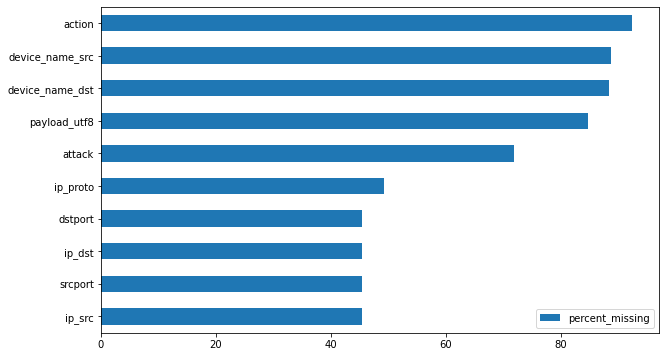

In [473]:
( df.isnull().sum() * 100 / len(df) ).to_frame(name='percent_missing').query('percent_missing>0').sort_values(by='percent_missing', ascending=True).plot.barh( figsize=(10,6));

# **Preprocessing**:

### ***Converting unix timestamp string to readable date***: 

In [474]:
def get_night(x):
    night = [21, 22, 23, 0, 1, 2, 3, 4, 5]
    
    if x in night:
        return 1
    else:
        return 0


def get_time(row):
    '''Convert from Unix to Datetime.'''
    return datetime.utcfromtimestamp(float(row)).strftime('%Y-%m-%d %H:%M:%S')



def get_datetime_info(df):
    
    df['frame_time_epoch'] = df['frame_time_epoch'].apply(get_time)
    df["frame_epoch_datetime"] = pd.to_datetime(df['frame_time_epoch'])
    # Get day to retrieve activity
    df["frame_epoch_day"] = df["frame_epoch_datetime"].dt.day
    df["frame_epoch_month"] = df["frame_epoch_datetime"].dt.month
    df["frame_epoch_weekday"] = df["frame_epoch_datetime"].dt.weekday
    df["frame_epoch_hour"] = df["frame_epoch_datetime"].dt.hour
    
    df["frame_epoch_night"] = df["frame_epoch_hour"].apply(get_night)
    
    df.drop(columns=["frame_time_epoch"], inplace=True)
    
    return df


get_datetime_info(df)

,frame_len,eth_src,device_name_src,eth_dst,device_name_dst,eth_type,ip_src,...,attack,frame_epoch_datetime,frame_epoch_day,frame_epoch_month,frame_epoch_weekday,frame_epoch_hour,frame_epoch_night
0,66,04:CF:4B:3B:00:58,NaN,0E:F2:26:7D:04:1A,NaN,0x0800,18.196.142.136,...,NaN,2023-01-26 15:24:14,26,1,3,15,0
1,303,A8:03:2A:B1:35:60,NaN,04:CF:4B:3B:00:58,NaN,0x0800,192.168.12.80,...,NaN,2023-01-26 15:24:14,26,1,3,15,0
2,66,0E:F2:26:7D:04:1A,NaN,04:CF:4B:3B:00:58,NaN,0x0800,192.168.12.148,...,NaN,2023-01-26 15:24:14,26,1,3,15,0
3,54,04:CF:4B:3B:00:58,NaN,A8:03:2A:B1:35:60,NaN,0x0800,34.140.193.14,...,NaN,2023-01-26 15:24:14,26,1,3,15,0
4,128,0E:F2:26:7D:04:1A,NaN,FF:FF:FF:FF:FF:FF,NaN,0x0800,192.168.12.148,...,NaN,2023-01-26 15:24:16,26,1,3,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4963,790,A8:03:2A:B1:35:60,NaN,01:00:5E:00:00:FB,NaN,0x0800,192.168.12.80,...,NaN,2023-01-26 15:46:43,26,1,3,15,0
4964,128,0E:F2:26:7D:04:1A,NaN,FF:FF:FF:FF:FF:FF,NaN,0x0800,192.168.12.148,...,NaN,2023-01-26 15:46:44,26,1,3,15,0
4965,128,0E:F2:26:7D:04:1A,NaN,FF:FF:FF:FF:FF:FF,NaN,0x0800,192.168.12.148,...,NaN,2023-01-26 15:46:44,26,1,3,15,0
4966,78,0E:F2:26:7D:04:1A,NaN,D8:F1:5B:D8:08:0C,LDR TUYA,0x0800,192.168.12.148,...,NaN,2023-01-26 15:46:45,26,1,3,15,0


In [475]:
print("Start date:", df["frame_epoch_datetime"].min(), "\n"+
      "Finish date:", df["frame_epoch_datetime"].max()) 

Start date: 2023-01-26 15:24:14 
Finish date: 2023-01-26 15:46:45


### ***Macadresses mapping***: 

In [476]:
src_mac_adressen_mapping = df.loc[df['eth_src'].notna() & df["device_name_src"].notna() ][['eth_src','device_name_src']]
src_mac_adressen_mapping.drop_duplicates()

,eth_src,device_name_src
6,D8:F1:5B:D8:08:0C,LDR TUYA
8,60:01:94:C7:69:AC,Lampe2
24,48:E1:E9:44:4C:52,GARAGE_DOOR
227,54:AF:97:7C:5E:F0,SmartSocket1


In [477]:
dst_mac_adressen_mapping = df.loc[df['eth_dst'].notna() & df["device_name_dst"].notna() ][['eth_dst','device_name_dst']]
des_mac_adressen_mapping.drop_duplicates()

,eth_dst,device_name_dst
9,60:01:94:C7:69:AC,Lampe2
11,D8:F1:5B:D8:08:0C,LDR TUYA
23,48:E1:E9:44:4C:52,GARAGE_DOOR
2314,54:AF:97:7C:5E:F0,SmartSocket1


### ***payload_utf8 column cleaning***: 

#### Replacing non-printable ASCII characters like '\x17\x03\x03' with NAN values

In [511]:
df['payload_utf8'] = df['payload_utf8'].astype(str)
df['payload_utf8'] = np.where(~df['payload_utf8'].str.startswith('{') & ~df['payload_utf8'].str.endswith('}'), '', df['payload_utf8'])
df['payload_utf8'] = df.payload_utf8.replace('',np.nan,regex = True)

In [512]:
df.loc[df['payload_utf8'].notna()].head()

,frame_time_epoch,frame_len,eth_src,device_name_src,eth_dst,device_name_dst,eth_type,ip_src,srcport,ip_dst,dstport,ip_proto,payload_utf8,action,attack
25,1.674747e+09,123,AC:0B:FB:D8:38:4E,NaN,FF:FF:FF:FF:FF:FF,NaN,0x0800,192.168.12.213,8888.0,192.168.12.255,8080.0,17.0,"{""device"":""ALPHA"",""mac"":""AC:0B:FB:D8:38:4E"",""sensor"":""LDR TUYA"",""value"":""237.00""}",NaN,NaN
26,1.674747e+09,123,AC:0B:FB:D8:38:4E,NaN,FF:FF:FF:FF:FF:FF,NaN,0x0800,192.168.12.213,8888.0,192.168.12.255,8080.0,17.0,"{""device"":""ALPHA"",""mac"":""AC:0B:FB:D8:38:4E"",""sensor"":""LDR TUYA"",""value"":""237.00""}",NaN,NaN
30,1.674747e+09,158,04:CF:4B:3B:00:38,NaN,04:CF:4B:3B:00:58,NaN,0x0800,192.168.12.110,53.0,192.168.12.1,53.0,17.0,"{""attack"": ""hostscan"", ""target"": ""192.168.12.1"", ""MAC"": ""04:cf:4b:3b:00:38"", ""type"": ""start"", ""time"": 1674746658774}",NaN,NaN
1082,1.674747e+09,124,AC:0B:FB:D8:38:4E,NaN,FF:FF:FF:FF:FF:FF,NaN,0x0800,192.168.12.213,8888.0,192.168.12.255,8080.0,17.0,"{""device"":""ALPHA"",""mac"":""AC:0B:FB:D8:38:4E"",""sensor"":""LDR TUYA"",""value"":""-661.00""}",NaN,NaN
1083,1.674747e+09,124,AC:0B:FB:D8:38:4E,NaN,FF:FF:FF:FF:FF:FF,NaN,0x0800,192.168.12.213,8888.0,192.168.12.255,8080.0,17.0,"{""device"":""ALPHA"",""mac"":""AC:0B:FB:D8:38:4E"",""sensor"":""LDR TUYA"",""value"":""-661.00""}",NaN,NaN
